In [36]:
import pandas as pd

In [37]:
# Data Source: https://archive.ics.uci.edu/dataset/352/online+retail

file_path = 'csv/Online Retail.xlsx'
df = pd.read_excel(file_path, parse_dates=['InvoiceDate'])

In [38]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [39]:
# Remove rows without a CustomerID  
df = df.dropna(subset=['CustomerID'])

# Keep only positive quantities (remove returns or errors)  
df = df[df['Quantity'] > 0]

# Calculate total revenue per transaction  
df['Revenue'] = df['Quantity'] * df['UnitPrice']


<br><br><br><br>

# Deterministic Approach

| **Step** | **Description** |
|-----------|-----------------|
| **1. Calculate average order value** | Find how much a customer spends on average per purchase (`avg_order_value`). |
| **2. Calculate purchase frequency per month** | Estimate how many purchases the customer makes each month (`frequency_per_month`). |
| **3. Define assumptions** | Set two constants: average customer lifespan (`avg_lifespan`, e.g., 12 months) and profit margin (`margin`, e.g., 0.1 or 10%). |
| **4. Compute deterministic CLV** | Multiply all components: `CLV = avg_order_value × frequency_per_month × avg_lifespan × margin`. |

In [ ]:
# Group data by customer to calculate purchase metrics
customer = df.groupby('CustomerID').agg(
    frequency=('InvoiceNo', 'nunique'),          # Number of unique purchases per customer
    total_revenue=('Revenue', 'sum'),            # Total revenue generated by each customer
    monetary_value=('Revenue', 'mean'),          # Average revenue per transaction
    first_purchase_date=('InvoiceDate', 'min'),  # Date of the first purchase
    last_purchase_date=('InvoiceDate', 'max')    # Date of the last purchase
).reset_index()


# Step 1 -------------------------------
# Calculate average order value
customer['avg_order_value'] = customer['total_revenue'] / customer['frequency']


# Step 2 ------------------------------- 
# Calculate relationship duration in months
customer['months'] = (customer['last_purchase_date'] - customer['first_purchase_date']).dt.days / 30

# Calculate purchase frequency per month (avoid division by zero)
customer['frequency_per_month'] = customer['frequency'] / customer['months'].replace(0, 1)


# Step 3 -------------------------------
# Define assumptions for average lifespan (in months) and profit margin
avg_lifespan = 12
margin = 0.1


# Step 4 -------------------------------
# Estimate deterministic Customer Lifetime Value (CLV)
customer['CLV'] = customer['avg_order_value'] * customer['frequency_per_month'] * avg_lifespan * margin


# Extra Step - Create Recency and T for the Probabilist approach -------------------------------
# Calculate recency (days between first and last purchase)
customer['recency'] = (customer['last_purchase_date'] - customer['first_purchase_date']).dt.days

# Calculate T (days between first purchase and the end of observation period)
max_date = df['InvoiceDate'].max()  # Last date in the dataset
customer['T'] = (max_date - customer['first_purchase_date']).dt.days



customer.head()


,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,avg_order_value,months,frequency_per_month,CLV,recency,T
0,12346.0,1,77183.60,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,77183.600000,0.000000,1.000000,92620.320000,0,325
1,12347.0,7,4310.00,23.681319,2010-12-07 14:57:00,2011-12-07 15:52:00,615.714286,12.166667,0.575342,425.095890,365,366
2,12348.0,4,1797.24,57.975484,2010-12-16 19:09:00,2011-09-25 13:13:00,449.310000,9.400000,0.425532,229.434894,282,357
3,12349.0,1,1757.55,24.076027,2011-11-21 09:51:00,2011-11-21 09:51:00,1757.550000,0.000000,1.000000,2109.060000,0,18
4,12350.0,1,334.40,19.670588,2011-02-02 16:01:00,2011-02-02 16:01:00,334.400000,0.000000,1.000000,401.280000,0,309


<br><br><br><br>

# Probabilistic Approach - Lifetimes

| **Step** | **Description** |
|-----------|-----------------|
| **1. Prepare the data** | Clean the dataset (remove missing `CustomerID` and negative quantities) and calculate `Revenue = Quantity * UnitPrice`. Create a customer-level table with `frequency`, `recency`, `T`, and `monetary_value`. |
| **2. Fit the frequency model (BG/NBD)** | Use `BetaGeoFitter` to estimate how often each customer is expected to make future purchases. |
| **3. Fit the monetary model (Gamma-Gamma)** | Use `GammaGammaFitter` to predict the expected average spend per purchase for each customer. |
| **4. Calculate CLV** | Combine both models with `customer_lifetime_value()` to estimate each customer’s total expected value over a given time horizon (e.g., 6 months). |

### Step 1 - Prepare the data

In [41]:
# Import probabilistic models for CLV estimation (BG/NBD and Gamma-Gamma)
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Keep only customers with more than one purchase and positive monetary value
summary = customer[(customer['frequency'] > 1) & (customer['monetary_value'] > 0)]

In [50]:
summary.describe()

,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,avg_order_value,months,frequency_per_month,CLV,recency,T,expected_purchases_6m,expected_avg_value,clv_6m
count,2845.000000,2845.000000,2845.000000,2845.000000,2845,2845,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2.845000e+03,2845.000000,2.845000e+03
mean,15292.165554,5.990158,2915.675280,57.427821,2011-03-26 18:12:51.205623808,2011-10-12 03:47:29.504393728,422.473197,6.630182,1.761988,743.741094,198.905448,257.272056,3.955035e+00,55.895015,1.866418e+02
min,12347.000000,2.000000,6.900000,2.150588,2010-12-01 08:26:00,2010-12-01 15:28:00,3.450000,0.000000,0.164384,4.012683,0.000000,2.000000,2.822321e-24,3.046087,4.966797e-23
25%,13817.000000,2.000000,616.790000,12.279333,2010-12-16 18:23:00,2011-09-25 13:39:00,193.497500,3.266667,0.481283,148.400471,98.000000,191.000000,2.133296e+00,13.056558,3.108555e+01
50%,15265.000000,4.000000,1160.070000,18.127297,2011-03-02 08:26:00,2011-11-09 16:03:00,303.716667,6.900000,0.756303,287.294118,207.000000,282.000000,3.224428e+00,18.705266,5.583548e+01
75%,16792.000000,6.000000,2445.910000,25.314828,2011-06-01 12:33:00,2011-11-28 17:09:00,441.575000,9.966667,1.344538,564.312000,299.000000,357.000000,4.792283e+00,25.566621,1.008481e+02
max,18287.000000,210.000000,280206.020000,56157.500000,2011-12-07 12:14:00,2011-12-09 12:50:00,84236.250000,12.433333,1020.000000,194083.560000,373.000000,373.000000,8.271983e+01,52305.414798,1.250491e+05
std,1718.649301,9.054720,10904.082493,1087.288601,NaN,NaN,1658.556318,3.795565,19.436105,4227.644910,113.866961,103.016619,3.759579e+00,1014.190035,2.417611e+03


In [42]:
summary.head()

,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,avg_order_value,months,frequency_per_month,CLV,recency,T
1,12347.0,7,4310.00,23.681319,2010-12-07 14:57:00,2011-12-07 15:52:00,615.714286,12.166667,0.575342,425.095890,365,366
2,12348.0,4,1797.24,57.975484,2010-12-16 19:09:00,2011-09-25 13:13:00,449.310000,9.400000,0.425532,229.434894,282,357
5,12352.0,8,2506.04,29.482824,2011-02-16 12:33:00,2011-11-03 14:37:00,313.255000,8.666667,0.923077,346.990154,260,296
9,12356.0,3,2811.43,47.651356,2011-01-18 09:50:00,2011-11-17 08:40:00,937.143333,10.066667,0.298013,335.137351,302,325
11,12358.0,2,1168.06,61.476842,2011-07-12 10:04:00,2011-12-08 10:26:00,584.030000,4.966667,0.402685,282.215839,149,150


### Step 2 - Fit the frequency model (BG/NBD)

In [43]:
# Create the model that will learn how often customers make purchases
# The small number (0.001) helps keep the model stable and avoid overfitting
bgf = BetaGeoFitter(penalizer_coef=0.001)

# Train the model using each customer's frequency, recency, and time observed
bgf.fit(summary['frequency'], summary['recency'], summary['T'])


<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.11, alpha: 79.08, b: 2.46, r: 2.17>

In [44]:
# Predict how many purchases each customer is expected to make in the next 180 days (6 months)
summary['expected_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180,                        # Time period to predict (in days)
    summary['frequency'],       # How many times the customer bought before
    summary['recency'],         # How recently they bought
    summary['T']                # How long they've been observed
)

### Step 3 - Fit the monetary model (Gamma-Gamma)

In [45]:
# Create the model that predicts how much money each customer spends on average
# The small number (0.001) helps keep the model stable and avoid overfitting
ggf = GammaGammaFitter(penalizer_coef=0.001)

# Train the model using how often each customer buys and how much they usually spend
ggf.fit(summary['frequency'], summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 5.01, q: 1.74, v: 4.85>

In [46]:
# Predict the expected average spending (order value) for each customer
summary['expected_avg_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],        # How often the customer buys
    summary['monetary_value']    # The average amount they usually spend
)

### Step 4 - Calculate CLV

In [47]:
# Calculate the predicted Customer Lifetime Value (CLV) for the next 6 months
summary['clv_6m'] = ggf.customer_lifetime_value(
    bgf,                      # Model that predicts how often customers will buy (BG/NBD)
    summary['frequency'],     # Number of past purchases
    summary['recency'],       # Time since last purchase
    summary['T'],             # Total time observed for each customer
    summary['monetary_value'],# Average spend per purchase
    time=6,                   # Prediction horizon (6 months)
    discount_rate=0.01        # Small discount for future money (1% per month)
)

<br><br><br><br>

# Comparing both approaches

In [48]:
# Add the predicted 6-month CLV from the summary table to the main customer table
customer = customer.merge(
    summary[['CustomerID', 'clv_6m']],  # Keep only the customer ID and CLV columns
    on='CustomerID',                    # Match rows using the CustomerID
    how='left'                          # Keep all customers, even if some have no CLV prediction
)

In [49]:
customer.head()

,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,avg_order_value,months,frequency_per_month,CLV,recency,T,clv_6m
0,12346.0,1,77183.60,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,77183.600000,0.000000,1.000000,92620.320000,0,325,NaN
1,12347.0,7,4310.00,23.681319,2010-12-07 14:57:00,2011-12-07 15:52:00,615.714286,12.166667,0.575342,425.095890,365,366,82.598432
2,12348.0,4,1797.24,57.975484,2010-12-16 19:09:00,2011-09-25 13:13:00,449.310000,9.400000,0.425532,229.434894,282,357,128.781830
3,12349.0,1,1757.55,24.076027,2011-11-21 09:51:00,2011-11-21 09:51:00,1757.550000,0.000000,1.000000,2109.060000,0,18,NaN
4,12350.0,1,334.40,19.670588,2011-02-02 16:01:00,2011-02-02 16:01:00,334.400000,0.000000,1.000000,401.280000,0,309,NaN


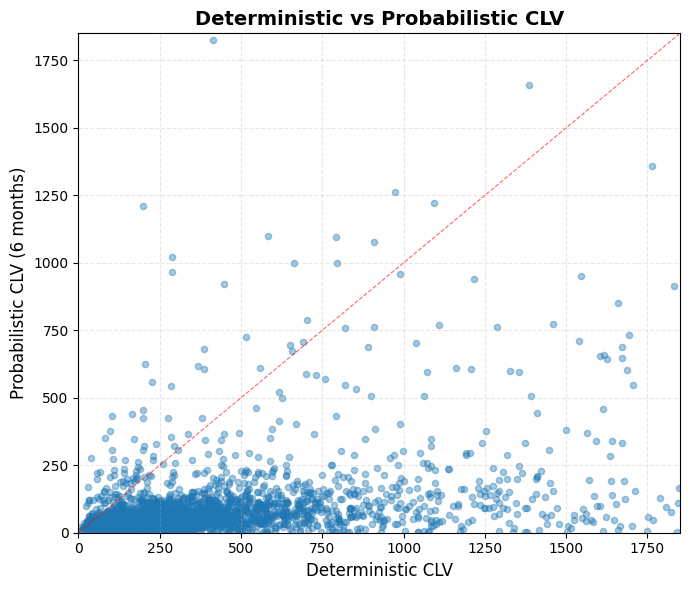

In [75]:
import matplotlib.pyplot as plt

# Get the CLV values from both models
x = customer['CLV']        # Deterministic CLV
y = customer['clv_6m']     # Probabilistic CLV (6 months)

# Use the same limit for both axes so the red line (x = y) looks correct
lim = min(x.quantile(0.99), y.quantile(0.99))

# Create the scatter plot
plt.figure(figsize=(7,6))
plt.scatter(x, y, alpha=0.4, s=20, color='#1f77b4')  # Each dot is a customer
plt.title('Deterministic vs Probabilistic CLV', fontsize=14, weight='bold')
plt.xlabel('Deterministic CLV', fontsize=12)
plt.ylabel('Probabilistic CLV (6 months)', fontsize=12)

# Set equal limits for both axes
plt.xlim(0, lim)
plt.ylim(0, lim)

# Add a red dashed line showing where both CLVs would be equal
plt.plot([0, lim], [0, lim], color='red', linestyle='--', linewidth=0.8, alpha=0.6)

# Add a light grid and adjust layout
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()